In [2]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import altair as alt
alt.data_transformers.enable('json')
alt.renderers.enable('jupyterlab')
from sublimpy import tidy, utils
import pytz
import datetime as dt

seconds_in_timestep = 60*30

from metpy.units import units
import pint_pandas
from metpy import constants
from scipy import interpolate
np.set_printoptions(suppress=True,precision=10)

# Parameters for calculations

In [3]:
heights = [1,3,10]
HORIZ_GRID_SPACING = 50
VERT_GRID_SPACING = 20
start_date = '20221130'
end_date = '20230509'
    # streamwise-coords
# tidy_df = pd.read_parquet(f"tidy_df_{start_date}_{end_date}_planar_fit_multiplane.parquet")
    # slope-adjusted earthwise-coords
tidy_df = pd.read_parquet(f"tidy_df_{start_date}_{end_date}_planar_fit.parquet")
    # sonic coords
# tidy_df = pd.read_parquet(f"tidy_df_{start_date}_{end_date}_noplanar_fit.parquet")

# method_numerical_advection = 'wind_divergence'      # q * d/dx_i (u_i)
# method_numerical_advection = 'scalar_divergence'    # u_i * d/dx_i (q)
# method_numerical_advection = 'summed'               # q * d/dx_i (u_i) + u_i * d/dx_i (q)
# method_numerical_advection = 'derivative'           # d/dx_i (q * u_i)

# Prepare data

## Open SOS Measurement Dataset

In [4]:
# convert time column to datetime
tidy_df['time'] = pd.to_datetime(tidy_df['time'])
tidy_df = utils.modify_df_timezone(tidy_df, pytz.UTC, 'US/Mountain')
# limit data to our dates of interest, based on continuous snow cover at Kettle Ponds
tidy_df = tidy_df.set_index('time').sort_index().loc[start_date:end_date].reset_index()

## Add combined blowing snow flux variable
tidy_df = tidy.tidy_df_add_variable(
    tidy_df,
    (
        tidy_df.query("variable == 'SF_avg_1m_ue'")['value'].values + 
        tidy_df.query("variable == 'SF_avg_2m_ue'")['value'].values
    ), 
    'SF_avg_ue', 'snow flux', 1, 'ue',
)

## Add absolute humidity measurements by converting hygrometer measurements

In [5]:
tower_height_keys = tidy_df[tidy_df.measurement=='specific humidity'].groupby(['tower', 'height']).indices.keys()
for t, h in tower_height_keys:
    this_tower_height_tidy_df = tidy_df.query(
            f"tower == '{t}'"
        ).query(
            f"height == {h}"
        )
    specific_humidity_values = this_tower_height_tidy_df.query(
            "measurement == 'specific humidity'"
        ).set_index('time')[['value']].rename(columns={'value': 'specific humidity'})
    air_density_values = this_tower_height_tidy_df.query(
            "measurement == 'air density'"
        ).set_index('time')[['value']].rename(columns={'value': 'air density'})
    combined_df = specific_humidity_values.join(air_density_values)

    abs_humidity_values = (
        combined_df['specific humidity'].values * units('g/g')
    ).to('g/kg') * (
        combined_df['air density'].values * units('kg/m^3')
    ).m

    tidy_df = tidy.tidy_df_add_variable(
        tidy_df,
        abs_humidity_values,
        f"absolutehumidity_{int(h)}m_{t}",
        'absolute humidity',
        int(h),
        t
    )

## Calibrate gas analyzer measurements

We calibrate by assuming that all gas analyzers have the same seasonal mean as the corresponding hygrometer measurement on the central tower (at a given height)

In [6]:
hygrometer_absolute_humidity_mean = (
    1000 * tidy_df[tidy_df.measurement=='specific humidity'].groupby(['tower', 'height'])[['value']].mean() *\
    tidy_df[tidy_df.measurement=='air density'].groupby(['tower', 'height'])[['value']].mean()
).reset_index().query("tower == 'c'")

In [7]:
ec_absolute_humidity_mean = tidy_df[tidy_df.measurement=='Carbon density'].groupby(['variable', 'tower', 'height'])[['value']].mean().reset_index()

In [8]:
corrections_df = ec_absolute_humidity_mean.merge(
    hygrometer_absolute_humidity_mean[['height', 'value']].rename(columns={'value': 'truth'}),
    on='height'
)
corrections_df['offset'] = corrections_df['value'] - corrections_df['truth']
corrections_df

,variable,tower,height,value,truth,offset


Update dataset with corrections

In [9]:
src = tidy_df[tidy_df.measurement=='Carbon dioxide density']
src = src[src.height.isin([1,3,10])]
src

,time,variable,value,height,tower,measurement
7,2022-11-30 00:00:00,co2_10m_c,0.673697,10.0,c,Carbon dioxide density
16,2022-11-30 00:00:00,co2_1m_c,0.480831,1.0,c,Carbon dioxide density
37,2022-11-30 00:00:00,co2_3m_uw,0.658807,3.0,uw,Carbon dioxide density
79,2022-11-30 00:00:00,co2_10m_ue,0.798188,10.0,ue,Carbon dioxide density
249,2022-11-30 00:00:00,co2_1m_ue,0.832681,1.0,ue,Carbon dioxide density
...,...,...,...,...,...,...
6502461,2023-05-09 17:30:00,co2_3m_d,0.719391,3.0,d,Carbon dioxide density
6502464,2023-05-09 17:30:00,co2_10m_d,0.580511,10.0,d,Carbon dioxide density
6502576,2023-05-09 17:30:00,co2_1m_uw,NaN,1.0,uw,Carbon dioxide density
6502799,2023-05-09 17:30:00,co2_3m_c,0.531596,3.0,c,Carbon dioxide density


In [10]:
alt.Chart(
    (
    1000 * tidy_df[tidy_df.measurement=='specific humidity'].groupby(['tower', 'height'])[['value']].mean() *\
    tidy_df[tidy_df.measurement=='air density'].groupby(['tower', 'height'])[['value']].mean()
    ).reset_index()
).mark_point(shape='square', filled=True, color='black', size=20).encode(
    alt.X("value:Q"),
    alt.Y("height:Q")
).properties(width=150, height = 150)\
+ alt.Chart(
    tidy_df[tidy_df.measurement=='Carbon dioxide density'].groupby(['variable', 'tower', 'height'])[['value']].mean().reset_index()
).mark_circle(size=40).encode(
    alt.X("value:Q"),
    alt.Y("height:Q"),
    alt.Color('tower:N')
).properties(width=150, height = 150)

<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


In [11]:


alt.Chart(
    src[ src.time > '20221212' ][ src.time < '20221214' ]
).mark_line().encode(
    alt.X("time:T"),
    alt.Y("value:Q"),
    alt.Color("height:N"),
    detail='variable'
)

/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_77791/1085128452.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  src[ src.time > '20221212' ][ src.time < '20221214' ]


<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


In [12]:
for idx, row in corrections_df.iterrows():
    src = tidy_df.query(f"variable == '{row['variable']}'")
    src = src.assign(value = src.value - row['offset'])
    tidy_df = tidy_df[tidy_df.variable != row['variable']]
    tidy_df = pd.concat([tidy_df, src])

In [13]:
alt.Chart(
    (
    1000 * tidy_df[tidy_df.measurement=='specific humidity'].groupby(['tower', 'height'])[['value']].mean() *\
    tidy_df[tidy_df.measurement=='air density'].groupby(['tower', 'height'])[['value']].mean()
    ).reset_index()
).mark_point(shape='square', filled=True, color='black', size=20).encode(
    alt.X("value:Q"),
    alt.Y("height:Q")
).properties(width=150, height = 150)\
+ alt.Chart(
    tidy_df[tidy_df.measurement=='Carbon dioxide density'].groupby(['variable', 'tower', 'height'])[['value']].mean().reset_index()
).mark_circle(size=40).encode(
    alt.X("value:Q"),
    alt.Y("height:Q"),
    alt.Color('tower:N')
).properties(width=150, height = 150)

<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


In [14]:
src = tidy_df[tidy_df.measurement=='Carbon dioxide density']
src = src[src.height.isin([1,3,10])]
abs_hum = alt.Chart(
    src[ src.time > '20221212' ][ src.time < '20221214' ]
).mark_line(strokeWidth=0.5).encode(
    alt.X("time:T"),
    alt.Y("value:Q").title("Absolute humidity (g/m^3)").scale(zero=False),
    alt.Color("height:N"),
    alt.Shape('tower:N'),
    detail='variable'
).properties(width=600)

src = tidy_df[tidy_df.measurement=='snow depth']
snowdepth = alt.Chart(
    src[ src.time > '20221212' ][ src.time < '20221214' ]
).mark_line(strokeWidth=0.5).encode(
    alt.X("time:T"),
    alt.Y("value:Q").title("Snow depth (m)"),
    alt.Shape('tower:N'),
    detail='variable'
).properties(width=600, height=150)

(snowdepth & abs_hum).resolve_scale(color='independent', shape='independent')

/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_77791/3209715685.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  src[ src.time > '20221212' ][ src.time < '20221214' ]
/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_77791/3209715685.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  src[ src.time > '20221212' ][ src.time < '20221214' ]


<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


# Identify categories for timestamps

In [15]:
# Identify lists of timestamps for different categories
bs_times = tidy_df.query("variable == 'SF_avg_ue'").query("value > 0").time
nobs_times = tidy_df.query("variable == 'SF_avg_ue'").query("value == 0").time

decoupled_times = tidy_df.query("variable == 'omega_3m_c'").query("value < 0.43").time
weaklycoupled_times = tidy_df.query("variable == 'omega_3m_c'").query("value >= 0.43").query("value <= 0.61").time
coupled_times = tidy_df.query("variable == 'omega_3m_c'").query("value > 0.61").time

ri_stable_times = tidy_df.query("variable == 'Ri_3m_c'").query("value > 0.25").time
ri_unstable_times = tidy_df.query("variable == 'Ri_3m_c'").query("value < -0.01").time
ri_neutral_times = tidy_df.query("variable == 'Ri_3m_c'").query("value >= -0.01").query("value <= 0.25").time

tgrad_stable_times = tidy_df.query("variable == 'temp_gradient_3m_c'").query("value > 0.01").time
tgrad_unstable_times = tidy_df.query("variable == 'temp_gradient_3m_c'").query("value < -0.01").time
tgrad_neutral_times = tidy_df.query("variable == 'temp_gradient_3m_c'").query("value >= -0.01").query("value <= 0.01").time

december_times = tidy_df[tidy_df.time.dt.month == 12].time
january_times = tidy_df[tidy_df.time.dt.month == 1].time
february_times = tidy_df[tidy_df.time.dt.month == 2].time
march_times = tidy_df[tidy_df.time.dt.month == 3].time
april_times = tidy_df[tidy_df.time.dt.month == 4].time

midwinter_times = tidy_df[tidy_df.time < '20230320'].time
spring_times = tidy_df[tidy_df.time > '20230320'].time

In [16]:
precip_df = xr.open_dataset("/Users/elischwat/Development/data/sublimationofsnow/precip_danny/precipitation_rate_gts_w23.nc")['corrected_prcp_rate_m2'].to_dataframe()

is_snowing_dates = pd.concat([
    precip_df.query("corrected_prcp_rate_m2 > 0").index.to_series(),
    precip_df.query("corrected_prcp_rate_m2 > 0").index.to_series() + dt.timedelta(minutes=30)
])
    
is_not_snowing_dates = pd.concat([
    precip_df.query("corrected_prcp_rate_m2 <= 0").index.to_series(),
    precip_df.query("corrected_prcp_rate_m2 <= 0").index.to_series() + dt.timedelta(minutes=30)
])

# Create tables

## Instrument location info (georeferenced)
We use a file with theodolite/GPS readings provided by NCAR. 

In [17]:
instrument_loc_df = pd.read_csv("~/Development/data/sublimationofsnow/SOSm.txt", names = ['ec', 'x', 'y', 'z'])
instrument_loc_df = instrument_loc_df[ 
    instrument_loc_df['ec'].str.startswith('CS')
    |
    instrument_loc_df['ec'].str.startswith('DS') 
    |
    instrument_loc_df['ec'].str.startswith('UWS') 
    |
    instrument_loc_df['ec'].str.startswith('UES') 
]
instrument_loc_df = instrument_loc_df[ 
    instrument_loc_df['ec'].str.endswith('T') 
    |
    instrument_loc_df['ec'].str.endswith('B') 
]
instrument_loc_df['top or bottom'] = instrument_loc_df['ec'].str[-1]
instrument_loc_df['tower'] = instrument_loc_df['ec'].apply(lambda str: str.split('S')[0].lower())
instrument_loc_df['height'] = instrument_loc_df['ec'].apply(lambda str: int(str.split('S')[1][:-1]))
instrument_loc_df = instrument_loc_df.drop(columns='ec')
instrument_loc_df = instrument_loc_df.pivot(index=['height', 'tower'], columns='top or bottom').reset_index()
instrument_loc_df = instrument_loc_df.set_index(['height', 'tower']).groupby(level=0, axis=1).mean()
instrument_loc_df

/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_77791/3668931392.py:21: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  instrument_loc_df = instrument_loc_df.set_index(['height', 'tower']).groupby(level=0, axis=1).mean()


x             y           z
height tower                                        
1      c      329002.47110  4.312171e+06  2861.36010
       d      329016.77615  4.312158e+06  2860.09135
       ue     329005.76010  4.312190e+06  2862.19275
       uw     328983.46715  4.312165e+06  2860.54055
2      c      329002.49025  4.312171e+06  2862.28475
3      c      329002.53920  4.312171e+06  2863.30060
       d      329016.82015  4.312158e+06  2862.02455
       ue     329005.80410  4.312190e+06  2864.12270
       uw     328983.52075  4.312165e+06  2862.50290
5      c      329002.53790  4.312171e+06  2865.33380
10     c      329002.65185  4.312171e+06  2870.36580
       d      329016.90980  4.312158e+06  2868.59560
       ue     329005.87765  4.312190e+06  2870.70875
       uw     328983.59905  4.312165e+06  2869.09490
15     c      329002.72120  4.312171e+06  2875.37755
20     c      329002.80045  4.312171e+06  2880.25445

## Wind field measurements

In [18]:
wind_field_df = tidy_df[tidy_df.measurement.isin(['u','v','w']) & tidy_df.height.isin(heights)]
wind_field_df = round(wind_field_df.pivot_table(index='time', columns=['height', 'tower', 'measurement'], values='value'), 4)
wind_field_df

height                 1.0                                                   \
tower                     c                       d                      ue   
measurement               u       v       w       u       v       w       u   
time                                                                          
2022-11-30 00:00:00  0.8442 -2.0019 -0.0388  0.8241 -1.8621 -0.0258  0.7621   
2022-11-30 00:30:00 -0.2592 -1.0267 -0.0255 -0.1717 -1.0263 -0.0297 -0.3245   
2022-11-30 01:00:00  0.2995 -1.1331 -0.0291  0.3493 -1.0744 -0.0199  0.2869   
2022-11-30 01:30:00  0.6549 -1.6004 -0.0338  0.6431 -1.4701 -0.0231  0.6043   
2022-11-30 02:00:00 -0.2904 -0.8675 -0.0303 -0.2469 -0.8933 -0.0251 -0.3630   
...                     ...     ...     ...     ...     ...     ...     ...   
2023-05-09 15:30:00  0.4570 -2.2166 -0.0320     NaN     NaN     NaN     NaN   
2023-05-09 16:00:00  0.4924 -3.0680 -0.0242     NaN     NaN     NaN     NaN   
2023-05-09 16:30:00  0.6614 -1.8370 -0.0195     NaN     NaN     NaN     NaN   
2023-05-09 17:00:00  0.7511 -2.5587 -0.0278     NaN     NaN     NaN     NaN   
2023-05-09 17:30:00  0.6576 -2.1972 -0.0169     NaN     NaN     NaN     NaN   

height                                       ...    10.0                  \
tower                                    uw  ...       c       d           
measurement               v       w       u  ...       w       u       v   
time                                         ...                           
2022-11-30 00:00:00 -1.9373 -0.0491  0.3113  ... -0.0823  2.5216 -2.1892   
2022-11-30 00:30:00 -1.0934 -0.0513 -0.2333  ... -0.0342 -0.0728 -0.8173   
2022-11-30 01:00:00 -1.1269 -0.0483  0.0885  ... -0.0566  0.6077 -0.6620   
2022-11-30 01:30:00 -1.5538 -0.0509  0.1304  ... -0.0922  1.8981 -1.5050   
2022-11-30 02:00:00 -0.9753 -0.0559 -0.2954  ... -0.0281 -0.0230 -0.5847   
...                     ...     ...     ...  ...     ...     ...     ...   
2023-05-09 15:30:00     NaN     NaN     NaN  ... -0.0880  1.4622 -2.9177   
2023-05-09 16:00:00     NaN     NaN     NaN  ... -0.1084  1.9826 -4.2441   
2023-05-09 16:30:00     NaN     NaN     NaN  ... -0.0782  1.8170 -2.2859   
2023-05-09 17:00:00     NaN     NaN     NaN  ... -0.1521  2.2542 -3.1893   
2023-05-09 17:30:00     NaN     NaN     NaN  ... -0.1077  2.5035 -2.6379   

height                                                                       
tower                            ue                      uw                  
measurement               w       u       v       w       u       v       w  
time                                                                         
2022-11-30 00:00:00 -0.0065  2.2063 -2.3716  0.0385  1.9062 -2.7111 -0.0001  
2022-11-30 00:30:00  0.0189 -0.2529 -0.7708  0.0288 -0.2268 -0.7774 -0.0121  
2022-11-30 01:00:00  0.0028  0.4626 -0.7354  0.0229  0.4762 -0.8680 -0.0210  
2022-11-30 01:30:00 -0.0322  1.7291 -1.6854 -0.0059  1.4609 -2.0032 -0.0751  
2022-11-30 02:00:00  0.0230 -0.1797 -0.4797  0.0546 -0.0708 -0.5148 -0.0342  
...                     ...     ...     ...     ...     ...     ...     ...  
2023-05-09 15:30:00  0.0055  1.0546 -2.9264 -0.0150  0.7188 -3.2364 -0.0674  
2023-05-09 16:00:00 -0.0841  1.5315 -4.1925 -0.0776  0.8299 -4.6255 -0.0672  
2023-05-09 16:30:00  0.0087  1.5308 -2.4116 -0.0206  1.2450 -2.6569 -0.0639  
2023-05-09 17:00:00 -0.0677  2.0220 -3.2202 -0.0637  1.2884 -3.6343 -0.0591  
2023-05-09 17:30:00 -0.0062  2.2296 -2.8267 -0.0377  1.7479 -3.1988 -0.0505  

[7485 rows x 36 columns]

## Turbulent Carbon dioxide vapor flux measurements

In [19]:
turb_flux_field_df = tidy_df[tidy_df.measurement.isin(['u_co2_','v_co2_','w_co2_']) & tidy_df.height.isin(heights)]
turb_flux_field_df = round(turb_flux_field_df.pivot_table(index='time', columns=['height', 'tower', 'measurement'], values='value'), 4)
turb_flux_field_df

height                 1.0                                                   \
tower                     c                       d                      ue   
measurement          u_co2_  v_co2_  w_co2_  u_co2_  v_co2_  w_co2_  u_co2_   
time                                                                          
2022-11-30 00:00:00  0.0003 -0.0004  0.0000  0.0002 -0.0005  0.0001  0.0007   
2022-11-30 00:30:00  0.0007 -0.0010  0.0000  0.0004 -0.0012  0.0000  0.0005   
2022-11-30 01:00:00  0.0005 -0.0002  0.0000  0.0000  0.0001  0.0000  0.0005   
2022-11-30 01:30:00 -0.0000  0.0001  0.0000 -0.0002  0.0001  0.0000  0.0002   
2022-11-30 02:00:00  0.0003 -0.0005  0.0000  0.0000 -0.0002  0.0000  0.0010   
...                     ...     ...     ...     ...     ...     ...     ...   
2023-05-09 15:30:00  0.0006 -0.0009  0.0001  0.0000  0.0000  0.0000  0.0000   
2023-05-09 16:00:00  0.0005 -0.0000  0.0001  0.0000  0.0000  0.0000  0.0000   
2023-05-09 16:30:00  0.0001  0.0001  0.0001  0.0000  0.0000  0.0000  0.0000   
2023-05-09 17:00:00  0.0003 -0.0003  0.0001  0.0000  0.0000  0.0000  0.0000   
2023-05-09 17:30:00 -0.0006 -0.0004  0.0001  0.0000  0.0000  0.0000  0.0000   

height                                       ...    10.0                  \
tower                                    uw  ...       c       d           
measurement          v_co2_  w_co2_  u_co2_  ...  w_co2_  u_co2_  v_co2_   
time                                         ...                           
2022-11-30 00:00:00  0.0002  0.0001 -0.0006  ... -0.0002  0.0047 -0.0005   
2022-11-30 00:30:00 -0.0015  0.0001 -0.0006  ... -0.0001  0.0029 -0.0009   
2022-11-30 01:00:00 -0.0006  0.0000 -0.0002  ...  0.0000  0.0015 -0.0001   
2022-11-30 01:30:00 -0.0001  0.0000 -0.0003  ... -0.0001  0.0014 -0.0002   
2022-11-30 02:00:00 -0.0006  0.0001 -0.0008  ... -0.0001  0.0015 -0.0003   
...                     ...     ...     ...  ...     ...     ...     ...   
2023-05-09 15:30:00  0.0000  0.0000  0.0000  ...  0.0001  0.0004 -0.0013   
2023-05-09 16:00:00  0.0000  0.0000  0.0000  ...  0.0002  0.0007 -0.0004   
2023-05-09 16:30:00  0.0000  0.0000  0.0000  ...  0.0001 -0.0002 -0.0001   
2023-05-09 17:00:00  0.0000  0.0000  0.0000  ...  0.0001  0.0003 -0.0002   
2023-05-09 17:30:00  0.0000  0.0000  0.0000  ...  0.0000  0.0003 -0.0008   

height                                                                       
tower                            ue                      uw                  
measurement          w_co2_  u_co2_  v_co2_  w_co2_  u_co2_  v_co2_  w_co2_  
time                                                                         
2022-11-30 00:00:00 -0.0002  0.0061 -0.0001 -0.0003  0.0039 -0.0011 -0.0003  
2022-11-30 00:30:00 -0.0001  0.0030 -0.0013  0.0000  0.0022 -0.0014 -0.0000  
2022-11-30 01:00:00  0.0000  0.0017 -0.0002 -0.0000  0.0014 -0.0007 -0.0001  
2022-11-30 01:30:00 -0.0001  0.0026 -0.0010 -0.0001  0.0009 -0.0003 -0.0000  
2022-11-30 02:00:00 -0.0000  0.0026 -0.0010  0.0000  0.0011  0.0002  0.0000  
...                     ...     ...     ...     ...     ...     ...     ...  
2023-05-09 15:30:00  0.0002  0.0003 -0.0010  0.0001  0.0005 -0.0013  0.0001  
2023-05-09 16:00:00 -0.0000 -0.0004  0.0000  0.0002  0.0008 -0.0005  0.0000  
2023-05-09 16:30:00  0.0001  0.0003 -0.0000  0.0001  0.0001 -0.0006  0.0001  
2023-05-09 17:00:00  0.0001  0.0008 -0.0002  0.0001  0.0011 -0.0010  0.0001  
2023-05-09 17:30:00  0.0001  0.0000 -0.0004  0.0001  0.0003 -0.0007  0.0000  

[7714 rows x 36 columns]

## Humidity measurements

In [20]:
abs_hum_field_df = tidy_df[tidy_df.measurement.isin(['Carbon dioxide density']) & tidy_df.height.isin(heights)]
abs_hum_field_df.measurement = 'q'
abs_hum_field_df = round(
    abs_hum_field_df.pivot_table(
        index='time', columns=['height', 'tower', 'measurement'], values='value'
    ), 
    4
)
abs_hum_field_df

/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_77791/2357749476.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  abs_hum_field_df.measurement = 'q'


height                 1.0                             3.0                   \
tower                     c       d      ue      uw       c       d      ue   
measurement               q       q       q       q       q       q       q   
time                                                                          
2022-11-30 00:00:00  0.4808  0.5004  0.8327  0.7022  0.6077  0.8662  0.4606   
2022-11-30 00:30:00  0.4784  0.4979  0.8357  0.7047  0.6042  0.8671  0.4604   
2022-11-30 01:00:00  0.4806  0.4985  0.8479  0.7055  0.6066  0.8746  0.4634   
2022-11-30 01:30:00  0.4823  0.4981  0.8553  0.7107  0.6087  0.8771  0.4641   
2022-11-30 02:00:00  0.4805  0.4983  0.8578  0.7074  0.6059  0.8806  0.4666   
...                     ...     ...     ...     ...     ...     ...     ...   
2023-05-09 15:30:00  0.4212     NaN     NaN     NaN  0.5307  0.7166  0.3961   
2023-05-09 16:00:00  0.4205     NaN     NaN     NaN  0.5301  0.7147  0.3954   
2023-05-09 16:30:00  0.4215     NaN     NaN     NaN  0.5306  0.7159  0.3955   
2023-05-09 17:00:00  0.4203     NaN     NaN     NaN  0.5294  0.7151  0.3947   
2023-05-09 17:30:00  0.4233     NaN     NaN     NaN  0.5316  0.7194  0.3962   

height                         10.0                          
tower                    uw       c       d      ue      uw  
measurement               q       q       q       q       q  
time                                                         
2022-11-30 00:00:00  0.6588  0.6737  0.6580  0.7982  0.5158  
2022-11-30 00:30:00  0.6583  0.6739  0.6521  0.7977  0.5089  
2022-11-30 01:00:00  0.6629  0.6757  0.6507  0.7996  0.5084  
2022-11-30 01:30:00  0.6662  0.6769  0.6495  0.8006  0.5091  
2022-11-30 02:00:00  0.6644  0.6745  0.6480  0.7985  0.5102  
...                     ...     ...     ...     ...     ...  
2023-05-09 15:30:00  0.5601  0.5941  0.5810  0.7024  0.4704  
2023-05-09 16:00:00  0.5591  0.5933  0.5794  0.7016  0.4699  
2023-05-09 16:30:00  0.5595  0.5931  0.5794  0.7016  0.4694  
2023-05-09 17:00:00  0.5580  0.5925  0.5791  0.7008  0.4696  
2023-05-09 17:30:00  0.5609  0.5933  0.5805  0.7020  0.4702  

[7485 rows x 12 columns]

## Advective flux measurements

In [21]:
ls = []
for h in wind_field_df.columns.get_level_values('height').unique():
    for t in wind_field_df.columns.get_level_values('tower').unique():
        this_wind_df = wind_field_df[(h,t)].copy()
        this_abs_hum_df = abs_hum_field_df[(h,t)].copy()  
        this_wind_df['uq'] = this_wind_df['u']*this_abs_hum_df['q']
        this_wind_df['vq'] = this_wind_df['v']*this_abs_hum_df['q']
        this_wind_df['wq'] = this_wind_df['w']*this_abs_hum_df['q']
        new = pd.concat([this_wind_df], axis=1, keys=[(h,t)])
        ls.append(new.drop(columns=[(h,t,'u'),(h,t,'v'),(h,t,'w')]))

adv_flux_field_df = ls[0]
for l in ls[1:]:
    adv_flux_field_df = adv_flux_field_df.join(l)
adv_flux_field_df.columns = adv_flux_field_df.columns.set_names('height', level=0)
adv_flux_field_df.columns = adv_flux_field_df.columns.set_names('tower', level=1)
adv_flux_field_df.head()

height                   1.0                                           \
tower                       c                             d             
measurement                uq        vq        wq        uq        vq   
time                                                                    
2022-11-30 00:00:00  0.405891 -0.962514 -0.018655  0.412380 -0.931795   
2022-11-30 00:30:00 -0.124001 -0.491173 -0.012199 -0.085489 -0.510995   
2022-11-30 01:00:00  0.143940 -0.544568 -0.013985  0.174126 -0.535588   
2022-11-30 01:30:00  0.315858 -0.771873 -0.016302  0.320328 -0.732257   
2022-11-30 02:00:00 -0.139537 -0.416834 -0.014559 -0.123030 -0.445131   

height                                                                 ...  \
tower                                ue                            uw  ...   
measurement                wq        uq        vq        wq        uq  ...   
time                                                                   ...   
2022-11-30 00:00:00 -0.012910  0.634601 -1.613190 -0.040886  0.218595  ...   
2022-11-30 00:30:00 -0.014788 -0.271185 -0.913754 -0.042871 -0.164407  ...   
2022-11-30 01:00:00 -0.009920  0.243263 -0.955499 -0.040954  0.062437  ...   
2022-11-30 01:30:00 -0.011506  0.516858 -1.328965 -0.043535  0.092675  ...   
2022-11-30 02:00:00 -0.012507 -0.311381 -0.836612 -0.047951 -0.208966  ...   

height                   10.0                                          \
tower                       c         d                            ue   
measurement                wq        uq        vq        wq        uq   
time                                                                    
2022-11-30 00:00:00 -0.055446  1.659213 -1.440494 -0.004277  1.761069   
2022-11-30 00:30:00 -0.023047 -0.047473 -0.532961  0.012325 -0.201738   
2022-11-30 01:00:00 -0.038245  0.395430 -0.430763  0.001822  0.369895   
2022-11-30 01:30:00 -0.062410  1.232816 -0.977497 -0.020914  1.384317   
2022-11-30 02:00:00 -0.018953 -0.014904 -0.378886  0.014904 -0.143490   

height                                                                 
tower                                          uw                      
measurement                vq        wq        uq        vq        wq  
time                                                                   
2022-11-30 00:00:00 -1.893011  0.030731  0.983218 -1.398385 -0.000052  
2022-11-30 00:30:00 -0.614867  0.022974 -0.115419 -0.395619 -0.006158  
2022-11-30 01:00:00 -0.588026  0.018311  0.242100 -0.441291 -0.010676  
2022-11-30 01:30:00 -1.349331 -0.004724  0.743744 -1.019829 -0.038233  
2022-11-30 02:00:00 -0.383040  0.043598 -0.036122 -0.262651 -0.017449  

[5 rows x 36 columns]

# Divergence calculations

In [22]:
def divergence(f,sp):
    """ 
    From: https://stackoverflow.com/a/67971515
    Computes divergence of vector field 
    f: array -> vector field components [Fx,Fy,Fz,...]
    sp: array -> spacing between points in respecitve directions [spx, spy,spz,...]
    """
    num_dims = len(f)
    return np.ufunc.reduce(np.add, [np.gradient(f[i], sp[i], axis=i) for i in range(num_dims)])

## Calculate interpolated fields

In [23]:
# Initialize lists to store results
wind_fields = []
advectedflux_fields = []
abshumidity_fields = []
grid_spacings = []
turbulentflux_fields = []
timestamps = []

for i in wind_field_df.index:
    if ( # sometimes we don't have all measurements - this ensures we only retrieve data that exists
        (i in wind_field_df.index) and (i in adv_flux_field_df.index) and  
        (i in abs_hum_field_df.index) and  (i in turb_flux_field_df.index)
    ):
        # Isolate wind speed (u_i) measurements for this timestamp
        wind_field_vals = pd.DataFrame(
            wind_field_df.loc[i]
        ).reset_index().set_index(['height', 'tower']).pivot(columns='measurement')
        wind_field_vals.columns = wind_field_vals.columns.droplevel(0)
        
        # Isolate advective flux (u_i*q) measurements for this timestamp
        adv_flux_field_vals = pd.DataFrame(
            adv_flux_field_df.loc[i]
        ).reset_index().set_index(['height', 'tower']).pivot(columns='measurement')
        adv_flux_field_vals.columns = adv_flux_field_vals.columns.droplevel(0)

        # Isolate humidity (q) measurements for this timestamp
        abs_humidity_field_vals = pd.DataFrame(
            abs_hum_field_df.loc[i]
        ).reset_index().set_index(['height', 'tower']).pivot(columns='measurement')
        abs_humidity_field_vals.columns = abs_humidity_field_vals.columns.droplevel(0)

        # Isolate turbulent flux (u_i'q') measurements for this timestamp
        turb_flux_field_vals = pd.DataFrame(
            turb_flux_field_df.loc[i]
        ).reset_index().set_index(['height', 'tower']).pivot(columns='measurement')
        turb_flux_field_vals.columns = turb_flux_field_vals.columns.droplevel(0)

        # Combine all measurements of fields and instrument locations into one dataframe
        points_and_fields = instrument_loc_df.join(
            wind_field_vals, how='right' # join on right df, so we drop instruments that we don't have measurements for
        ).join(
            adv_flux_field_vals,
        ).join(
            abs_humidity_field_vals,
        ).join(
            turb_flux_field_vals,
        ) 

        # Create a meshgrid for the interpolation
        xx, yy, zz = np.meshgrid(
            np.linspace(points_and_fields.x.min(), points_and_fields.x.max(), HORIZ_GRID_SPACING),
            np.linspace(points_and_fields.y.min(), points_and_fields.y.max(), HORIZ_GRID_SPACING),
            np.linspace(points_and_fields.z.min(), points_and_fields.z.max(), VERT_GRID_SPACING)
        )
        points = np.transpose(np.vstack((points_and_fields.x, points_and_fields.y, points_and_fields.z)))

        # Interpolate wind field
        u_interp = interpolate.griddata(points, points_and_fields['u'], (xx, yy, zz), method='linear')
        v_interp = interpolate.griddata(points, points_and_fields['v'], (xx, yy, zz), method='linear')
        w_interp = interpolate.griddata(points, points_and_fields['w'], (xx, yy, zz), method='linear')

        # Interpolate advected flux field
        uq_interp = interpolate.griddata(points, points_and_fields['uq'], (xx, yy, zz), method='linear')
        vq_interp = interpolate.griddata(points, points_and_fields['vq'], (xx, yy, zz), method='linear')
        wq_interp = interpolate.griddata(points, points_and_fields['wq'], (xx, yy, zz), method='linear')

        # Interpolate abs. humidity field
        q_interp = interpolate.griddata(points, points_and_fields['q'], (xx, yy, zz), method='linear')

        # Interpolate turbulent flux field
        u_q__interp = interpolate.griddata(points, points_and_fields['u_co2_'], (xx, yy, zz), method='linear')
        v_q__interp = interpolate.griddata(points, points_and_fields['v_co2_'], (xx, yy, zz), method='linear')
        w_q__interp = interpolate.griddata(points, points_and_fields['w_co2_'], (xx, yy, zz), method='linear')

        # Combine interpolated components into vector fields
        F = np.array([u_interp, v_interp, w_interp])
        Fq = np.array([uq_interp, vq_interp, wq_interp])
        F_q_ = np.array([u_q__interp, v_q__interp, w_q__interp])

        # Record grid spacing        
        sp_x = np.diff(xx[0,:,0]).mean()
        sp_y = np.diff(yy[:,0,0]).mean()
        sp_z = np.diff(zz[0,0,:]).mean()
        sp = [sp_x, sp_y, sp_z]

        # Append interpolated fields to our results lists
        wind_fields.append(F)
        advectedflux_fields.append(Fq)
        abshumidity_fields.append(q_interp)
        turbulentflux_fields.append(F_q_)
        grid_spacings.append(sp)
        timestamps.append(i)

## Calculate divergences


In [24]:
# Initialize lists to store results
div_wind_field_ls = []
div_wind_field_lateral_ls = []
div_wind_field_vertical_ls = []
div_advectedflux_field_ls = []
div_turbulentflux_field_ls = []
div_turbulentflux_field_lateral_ls = []
div_turbulentflux_field_vertical_ls = []
div_abshumidity_field_ls = []
div_advectedflux_field_scalargradient_ls = []
div_advectedflux_field_windgradient_ls = []
div_advectedflux_field_windgradient_lateral_ls = []
div_advectedflux_field_windgradient_vertical_ls = []

# iterate over each field (timestamp) and calculate divergences
for i in range(0, len(wind_fields)):
    wind_field          = wind_fields[i]
    advectedflux_field  = advectedflux_fields[i]
    abshumidity_field   = abshumidity_fields[i]
    turbulentflux_field = turbulentflux_fields[i]
    grid_spacing        = grid_spacings[i]

    # create wind fields with just lateral and vertical components
    wind_field_vertical_only = wind_field.copy()
    wind_field_lateral_only  = wind_field.copy()
    wind_field_vertical_only[0] = 0
    wind_field_vertical_only[1] = 0
    wind_field_lateral_only[2] = 0

    turbulentflux_field_vertical_only = turbulentflux_field.copy()
    turbulentflux_field_lateral_only = turbulentflux_field.copy()
    turbulentflux_field_vertical_only[0] = 0
    turbulentflux_field_vertical_only[1] = 0
    turbulentflux_field_lateral_only[2] = 0

    # calculate divergences

    # For humidity field
    div_abshumidity_field    = np.gradient(
        abshumidity_field,  grid_spacing[0],    axis=0
    ) + np.gradient(
        abshumidity_field,  grid_spacing[1],    axis=1
    ) + np.gradient(
        abshumidity_field,  grid_spacing[2],    axis=2
    )

    # For wind field
    div_wind_field          = divergence(wind_field, grid_spacing)
    div_wind_field_lateral  = divergence(wind_field_lateral_only, grid_spacing)
    div_wind_field_vertical  = divergence(wind_field_vertical_only, grid_spacing)

    # For turbulent flux
    div_turbulentflux_field = divergence(turbulentflux_field, grid_spacing)
    div_turbulentflux_field_lateral = divergence(turbulentflux_field_lateral_only, grid_spacing)
    div_turbulentflux_field_vertical = divergence(turbulentflux_field_vertical_only, grid_spacing)

    # For advected flux of form: d/dx (u_i q)
    div_advectedflux_field  = divergence(advectedflux_field, grid_spacing)
    # For advected flux of form: u d/dx (q)
    div_advectedflux_field_scalargradient   = wind_field*div_abshumidity_field
    # For advected flux of form: q d/dx (u)
    div_advectedflux_field_windgradient         = abshumidity_field*div_wind_field
    div_advectedflux_field_windgradient_lateral = abshumidity_field*div_wind_field_lateral
    div_advectedflux_field_windgradient_vertical= abshumidity_field*div_wind_field_vertical

    div_wind_field_ls.append(
        div_wind_field
    )
    div_wind_field_lateral_ls.append(
        div_wind_field_lateral
    )
    div_wind_field_vertical_ls.append(
        div_wind_field_vertical
    )
    div_advectedflux_field_ls.append(
        div_advectedflux_field
    )
    div_turbulentflux_field_ls.append(
        div_turbulentflux_field
    )
    div_turbulentflux_field_lateral_ls.append(
        div_turbulentflux_field_lateral
    )
    div_turbulentflux_field_vertical_ls.append(
        div_turbulentflux_field_vertical
    )
    div_abshumidity_field_ls.append(
        div_abshumidity_field
    )
    div_advectedflux_field_scalargradient_ls.append(
        div_advectedflux_field_scalargradient
    )
    div_advectedflux_field_windgradient_ls.append(
        div_advectedflux_field_windgradient
    )
    div_advectedflux_field_windgradient_lateral_ls.append(
        div_advectedflux_field_windgradient_lateral
    )
    div_advectedflux_field_windgradient_vertical_ls.append(
        div_advectedflux_field_windgradient_vertical
    )

## Calculate spatially averaged divergence values

In [25]:
conservation_spatial_mean_df = pd.DataFrame({
    'wind_field' : [
        np.nanmean(item) for item in div_wind_field_ls
    ],
    'wind_field_lateral' : [
        np.nanmean(item) for item in div_wind_field_lateral_ls
    ],
    'wind_field_vertical' : [
        np.nanmean(item) for item in div_wind_field_vertical_ls
    ],
    'div_advectedflux_field' : [
        np.nanmean(item) for item in div_advectedflux_field_ls
    ],
    'div_turbulentflux_field' : [
        np.nanmean(item) for item in div_turbulentflux_field_ls
    ],
    'div_turbulentflux_field_lateral' : [
        np.nanmean(item) for item in div_turbulentflux_field_lateral_ls
    ],
    'div_turbulentflux_field_vertical' : [
        np.nanmean(item) for item in div_turbulentflux_field_vertical_ls
    ],
    'div_abshumidity_field' : [
        np.nanmean(item) for item in div_abshumidity_field_ls
    ],
    'div_advectedflux_field_scalargradient' : [
        np.nanmean(item) for item in div_advectedflux_field_scalargradient_ls
    ],
    'div_advectedflux_field_windgradient' : [
        np.nanmean(item) for item in div_advectedflux_field_windgradient_ls
    ],
    'div_advectedflux_field_windgradient_lateral' : [
        np.nanmean(item) for item in div_advectedflux_field_windgradient_lateral_ls
    ],
    'div_advectedflux_field_windgradient_vertical' : [
        np.nanmean(item) for item in div_advectedflux_field_windgradient_vertical_ls
    ],
}, index = timestamps)

conservation_spatial_mean_df[
    'div_advectedflux_field_summed'
] = conservation_spatial_mean_df['div_advectedflux_field_scalargradient'] +\
    conservation_spatial_mean_df['div_advectedflux_field_windgradient']

/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_77791/3692211054.py:3: RuntimeWarning: Mean of empty slice
  np.nanmean(item) for item in div_wind_field_ls
/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_77791/3692211054.py:6: RuntimeWarning: Mean of empty slice
  np.nanmean(item) for item in div_wind_field_lateral_ls
/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_77791/3692211054.py:9: RuntimeWarning: Mean of empty slice
  np.nanmean(item) for item in div_wind_field_vertical_ls
/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_77791/3692211054.py:12: RuntimeWarning: Mean of empty slice
  np.nanmean(item) for item in div_advectedflux_field_ls
/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_77791/3692211054.py:24: RuntimeWarning: Mean of empty slice
  np.nanmean(item) for item in div_abshumidity_field_ls
/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_77791/3692211054.py:27: RuntimeWarning: Mean of empty slice
  np.nanmean

/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_77791/2958097553.py:7: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  conservation_spatial_mean_df.index.floor('30T').time


Text(0.5, 1.0, 'Advective divergences, 3 ways')

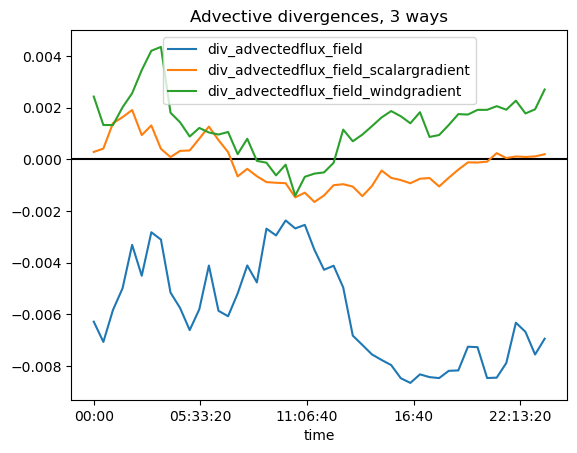

In [26]:
plt.axhline(0, color='k')
conservation_spatial_mean_df[[
    'div_advectedflux_field',
    'div_advectedflux_field_scalargradient',
    'div_advectedflux_field_windgradient',
]].groupby(
    conservation_spatial_mean_df.index.floor('30T').time
).mean().plot(ax=plt.gca())
plt.title("Advective divergences, 3 ways")

/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_77791/2962616717.py:7: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  conservation_spatial_mean_df.index.floor('30T').time


Text(0.5, 1.0, 'Advective divergence')

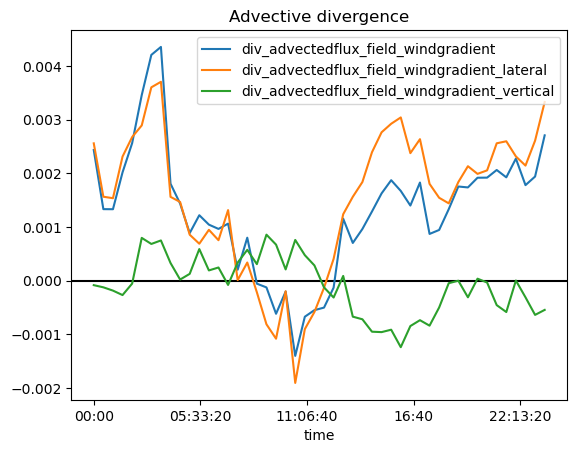

In [27]:
plt.axhline(0, color='k')
conservation_spatial_mean_df[[
    'div_advectedflux_field_windgradient',
    'div_advectedflux_field_windgradient_lateral',
    'div_advectedflux_field_windgradient_vertical',
]].groupby(
    conservation_spatial_mean_df.index.floor('30T').time
).mean().plot(ax=plt.gca())
plt.title("Advective divergence")

/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_77791/1731913438.py:7: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  conservation_spatial_mean_df.index.floor('30T').time


Text(0.5, 1.0, 'Turbulent divergence')

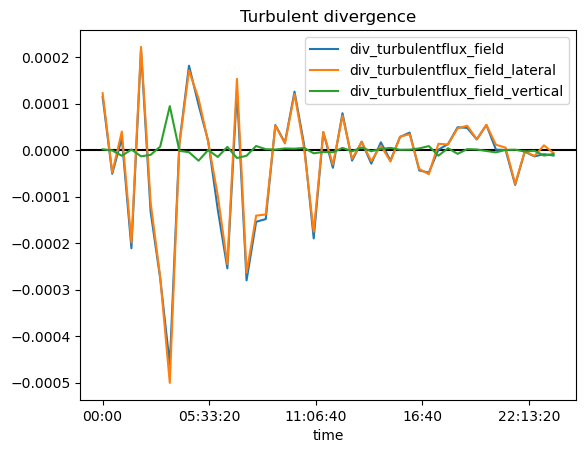

In [28]:
plt.axhline(0, color='k')
conservation_spatial_mean_df[[
    'div_turbulentflux_field',
    'div_turbulentflux_field_lateral',
    'div_turbulentflux_field_vertical',
]].groupby(
    conservation_spatial_mean_df.index.floor('30T').time
).mean().plot(ax=plt.gca())
plt.title("Turbulent divergence")

/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_77791/3908778584.py:6: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  conservation_spatial_mean_df.index.floor('30T').time


Text(0.5, 1.0, 'Advective and turbulent divergence')

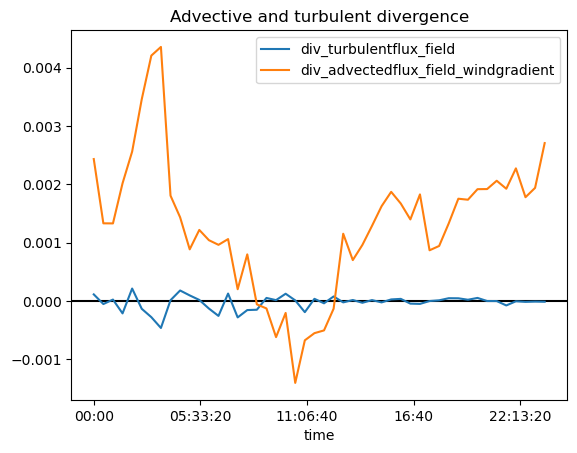

In [29]:
plt.axhline(0, color='k')
conservation_spatial_mean_df[[
    'div_turbulentflux_field',
    'div_advectedflux_field_windgradient'
]].groupby(
    conservation_spatial_mean_df.index.floor('30T').time
).mean().plot(ax=plt.gca())
plt.title("Advective and turbulent divergence")

/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_77791/876541519.py:10: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  src.index.floor('30T').time


Text(0.5, 1.0, 'Advective and turbulent divergence, not snowing or blowing')

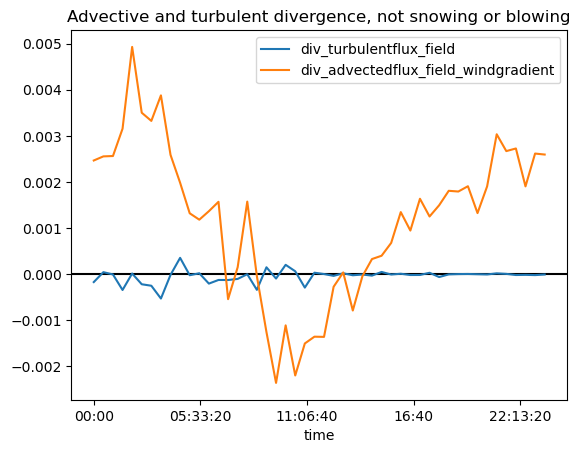

In [30]:
plt.axhline(0, color='k')
src = conservation_spatial_mean_df[
    conservation_spatial_mean_df.index.isin(nobs_times)
]
src = src[src.index.isin(is_not_snowing_dates)]
src[[
    'div_turbulentflux_field',
    'div_advectedflux_field_windgradient',
]].groupby(
    src.index.floor('30T').time
).mean().plot(ax=plt.gca())
plt.title("Advective and turbulent divergence, not snowing or blowing")

Text(0.5, 1.0, 'Advective and turbulent divergence, not snowing, is blowing')

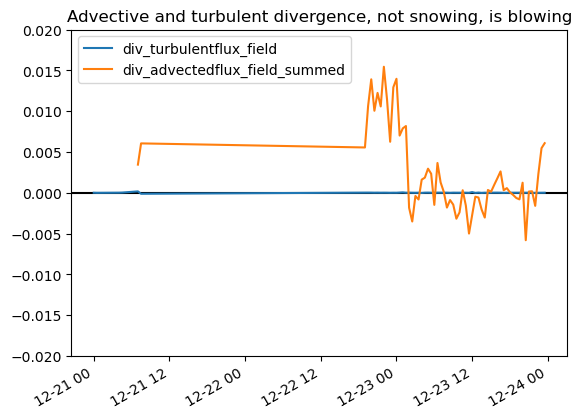

In [31]:
plt.axhline(0, color='k')
src = conservation_spatial_mean_df[
    conservation_spatial_mean_df.index.isin(nobs_times)
]
src = src[src.index.isin(is_not_snowing_dates)]
src[[
    'div_turbulentflux_field',
        'div_advectedflux_field_summed'
]].loc['20221221':'20221223'].plot(ax=plt.gca())
plt.ylim(-0.02, 0.02)
plt.title("Advective and turbulent divergence, not snowing, is blowing")

/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_77791/3159531664.py:10: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  src.index.floor('30T').time


Text(0.5, 1.0, 'Advective and turbulent divergence, not snowing or blowing')

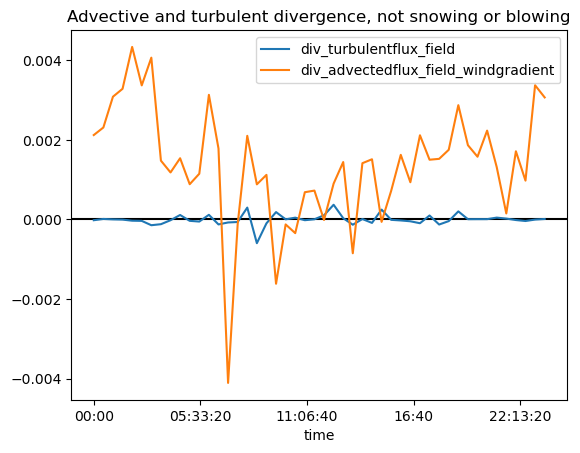

In [32]:
plt.axhline(0, color='k')
src = conservation_spatial_mean_df[
    conservation_spatial_mean_df.index.isin(nobs_times)
]
src = src[src.index.month == 12]
src[[
    'div_turbulentflux_field',
    'div_advectedflux_field_windgradient'
]].groupby(
    src.index.floor('30T').time
).mean().plot(ax=plt.gca())
plt.title("Advective and turbulent divergence, not snowing or blowing")

/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_77791/2998626858.py:10: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  src.index.floor('30T').time


Text(0.5, 1.0, 'Advective and turbulent divergence, not snowing or blowing')

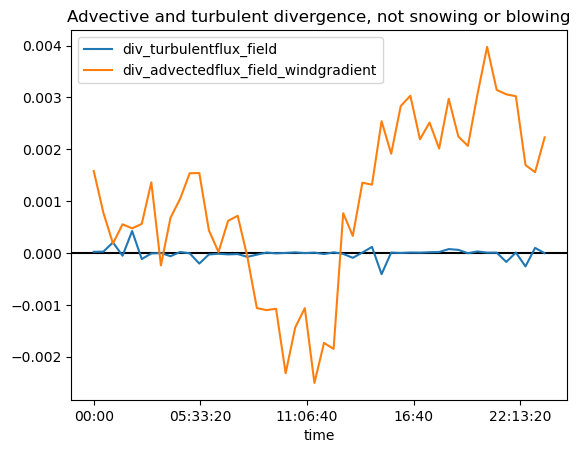

: 

In [33]:
plt.axhline(0, color='k')
src = conservation_spatial_mean_df[
    conservation_spatial_mean_df.index.isin(nobs_times)
]
src = src[src.index.month == 4]
src[[
    'div_turbulentflux_field',
    'div_advectedflux_field_windgradient'
]].groupby(
    src.index.floor('30T').time
).mean().plot(ax=plt.gca())
plt.title("Advective and turbulent divergence, not snowing or blowing")